In [85]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import access_spectrum as acs
from run_empca import *
import polyfit as pf
silent=False

Populating the interactive namespace from numpy and matplotlib


In [2]:
windowinfo = 'pickles/windowinfo.pkl'
elemwindows,window_all,window_peak,windowPeaks,windowPixels,tophats = acs.pklread(windowinfo)

In [3]:
specs = acs.pklread('red_clump/pickles/spectra_FE_H_u-0.4_d-0.5.pkl')[0]

In [4]:
errs = acs.pklread('red_clump/pickles/errs_FE_H_u-0.4_d-0.5.pkl')

In [5]:
SNR = specs/errs

In [6]:
vec = np.tile(elemwindows['C']+elemwindows['Al'],(specs.shape[0],1))

In [7]:
falsespecs = np.ma.masked_array(vec,specs.mask)

In [8]:
noise = falsespecs/SNR

In [9]:
drawn_noise = noise*np.random.randn(noise.shape[0],noise.shape[1])

In [10]:
falsespecs += drawn_noise

In [11]:
falsespecs.mask[np.where(noise<1e-10)] = True
noise.mask[np.where(noise<1e-10)] = True

In [97]:
def weight(elem,vec):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    return np.ma.sum(nw*vec)
    
def test_run(specs,noise,deltR2,nvecs):
    m1,m2,w1,w2 = pix_empca('nonvar',falsespecs.T,noise,'test.pkl',nvecs=nvecs,deltR2=2e-3,gen=True)
    resize_pix_eigvecs(falsespecs.T,m1,nstars=5)
    resize_pix_eigvecs(falsespecs.T,m2,nstars=5)
    m1elem = np.zeros((nvecs,len(elems)))
    m2elem = np.zeros((nvecs,len(elems)))
    for ind in range(len(elems)):
        for vec in range(5):
            m1elem[vec][ind] = weight(elems[ind],m1.eigvec[vec])
            m2elem[vec][ind] = weight(elems[ind],m2.eigvec[vec])

In [98]:
test_run(falsespecs,noise,2e-3,5)

       iter        R2             rchi2
EMPCA  1/25       0.00000010  26415.39792600
R2: 0.999890313768


In [88]:
m1elem = np.zeros((5,len(elems)))
for ind in range(len(elems)):
    for vec in range(5):
        m1elem[vec][ind] = np.ma.sum(np.ma.masked_array(pf.normweights(elemwindows[elems[ind]]))*m1.eigvec[vec])

In [89]:
m2elem = np.zeros((5,len(elems)))
for ind in range(len(elems)):
    for vec in range(5):
        m2elem[vec][ind] = np.ma.sum(np.ma.masked_array(pf.normweights(elemwindows[elems[ind]]))*m2.eigvec[vec])

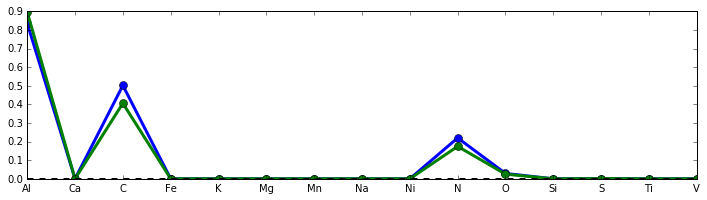

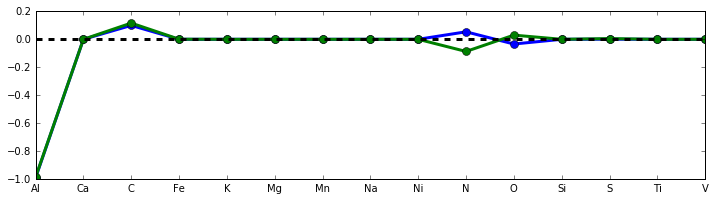

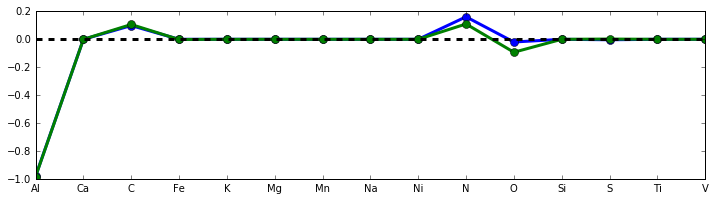

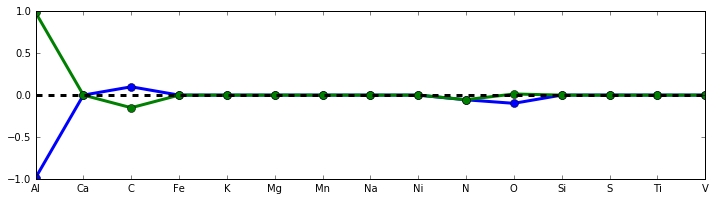

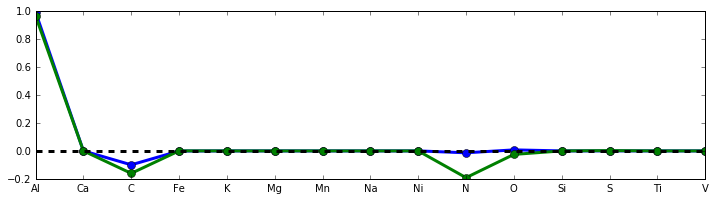

In [96]:
for n in range(5):
    plt.figure(figsize=(12,3))
    plt.plot(norm_eigvec(m1elem[n]),marker='o',linewidth = 3,markersize=8)
    plt.plot(norm_eigvec(m2elem[n]),marker='o',linewidth = 3,markersize=8)
    plt.axhline(0,linestyle='--',color='k',linewidth=3)
    plt.xticks(range(len(elems)),elems)